In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.column import _to_java_column, _to_seq, Column
from pyspark.dbutils import DBUtils

spark = SparkSession.builder.getOrCreate()
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)
spark.conf.set('spark.sql.repl.eagerEval.maxNumRows', 5)

In [9]:
dbutils = DBUtils(spark)
# display(dbutils.fs.ls("dbfs:/"))
dbutils.fs.ls("dbfs:/mnt")
# dbutils.fs.ls("dbfs:/mnt/sandboxes")

[FileInfo(path='dbfs:/mnt/Sandbox/', name='Sandbox/', size=0),
 FileInfo(path='dbfs:/mnt/SandboxStorage/', name='SandboxStorage/', size=0),
 FileInfo(path='dbfs:/mnt/adls/', name='adls/', size=0),
 FileInfo(path='dbfs:/mnt/bronze/', name='bronze/', size=0),
 FileInfo(path='dbfs:/mnt/gold/', name='gold/', size=0),
 FileInfo(path='dbfs:/mnt/mySandbox/', name='mySandbox/', size=0),
 FileInfo(path='dbfs:/mnt/sandboxes/', name='sandboxes/', size=0),
 FileInfo(path='dbfs:/mnt/silver/', name='silver/', size=0),
 FileInfo(path='dbfs:/mnt/system/', name='system/', size=0),
 FileInfo(path='dbfs:/mnt/training/', name='training/', size=0)]

In [3]:
# passthrough security is not supported by databricks-connect: 
# https://docs.microsoft.com/en-us/azure/databricks/security/credential-passthrough/adls-passthrough#known-limitations
# https://forums.databricks.com/questions/30402/azure-data-lake-storage-credential-passthrough-fro.html
# Companies = spark.read.format('delta').load("/mnt/sandboxes/SampleDataSets/All/Companies_All")

In [4]:
blob_account_name = "azureopendatastorage"
blob_container_name = "citydatacontainer"
blob_relative_path = "Safety/Release/city=Boston"
blob_sas_token = r"?st=2019-02-26T02%3A34%3A32Z&se=2119-02-27T02%3A34%3A00Z&sp=rl&sv=2018-03-28&sr=c&sig=XlJVWA7fMXCSxCKqJm8psMOh0W4h7cSYO28coRqF2fs%3D"

In [5]:
wasbs_path = 'wasbs://%s@%s.blob.core.windows.net/%s' % (blob_container_name, blob_account_name, blob_relative_path)
spark.conf.set('fs.azure.sas.%s.%s.blob.core.windows.net' % (blob_container_name, blob_account_name), blob_sas_token)
print('Remote blob path: ' + wasbs_path)

Remote blob path: wasbs://citydatacontainer@azureopendatastorage.blob.core.windows.net/Safety/Release/city=Boston


In [6]:
df_spark = spark.read.parquet(wasbs_path)
df_spark.createOrReplaceTempView('source')
df_spark.count()

1883120

In [7]:
resDf = spark.sql('SELECT * FROM source LIMIT 10')
resDf.show()

+--------+-----------+-------------------+--------------------+--------------------+------+--------------------+--------+---------+--------------------+------------------+
|dataType|dataSubtype|           dateTime|            category|         subcategory|status|             address|latitude|longitude|              source|extendedProperties|
+--------+-----------+-------------------+--------------------+--------------------+------+--------------------+--------+---------+--------------------+------------------+
|  Safety|    311_All|2020-07-28 02:24:06|     Street Cleaning|Requests for Stre...|Closed|694 Tremont St  R...| 42.3407| -71.0772|Citizens Connect App|                  |
|  Safety|    311_All|2021-02-04 12:32:00|       Street Lights|Street Light Outages|  Open|1259-1261 Dorches...| 42.3077| -71.0587|Citizens Connect App|                  |
|  Safety|    311_All|2012-11-15 10:05:03|          Sanitation|Schedule a Bulk I...|Closed|15 Park View St  ...| 42.3113| -71.0925|    Const

In [8]:
# File location and type
file_location = "/FileStore/tables/WA_Fn_UseC__Telco_Customer_Churn.csv"
file_type = "csv"

# CSV options
infer_schema = "false"
first_row_is_header = "true"
delimiter = ","

# The applied options are for CSV files. For other file types, these will be ignored.
df1_spark = spark.read.format(file_type) \
  .option("inferSchema", infer_schema) \
  .option("header", first_row_is_header) \
  .option("sep", delimiter) \
  .load(file_location)

df1_spark.show(5)


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [9]:
df1_spark.show(n=2, truncate=False, vertical=True)


-RECORD 0----------------------------
 customerID       | 7590-VHVEG       
 gender           | Female           
 SeniorCitizen    | 0                
 Partner          | Yes              
 Dependents       | No               
 tenure           | 1                
 PhoneService     | No               
 MultipleLines    | No phone service 
 InternetService  | DSL              
 OnlineSecurity   | No               
 OnlineBackup     | Yes              
 DeviceProtection | No               
 TechSupport      | No               
 StreamingTV      | No               
 StreamingMovies  | No               
 Contract         | Month-to-month   
 PaperlessBilling | Yes              
 PaymentMethod    | Electronic check 
 MonthlyCharges   | 29.85            
 TotalCharges     | 29.85            
 Churn            | No               
-RECORD 1----------------------------
 customerID       | 5575-GNVDE       
 gender           | Male             
 SeniorCitizen    | 0                
 Partner    

In [10]:
# spark built-in display
df1_spark


customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (au...,42.3,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes


In [11]:
import platform
import pandas as pd
import sklearn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

df = df1_spark.toPandas()
print(df.shape)
print(list(df.columns))
df.head()


(7043, 21)
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65,Yes


[17:01:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


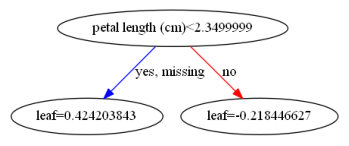

In [12]:
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from xgboost import plot_tree, to_graphviz
import graphviz

plt.style.use('ggplot')

# load data
data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

X_train, X_test, Y_train, Y_test = train_test_split(df[data.feature_names], df['target'], random_state=0)

# fit model no training data
model = XGBClassifier()
model.fit(X_train, Y_train)

# plot single tree
plot_tree(model)
plt.show()


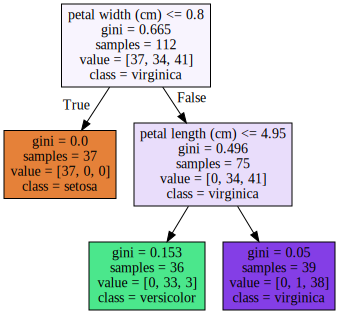

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

data = load_iris()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

X_train, X_test, Y_train, Y_test = train_test_split(df[data.feature_names], df['target'], random_state=0)

clf = DecisionTreeClassifier(max_depth=2, random_state=0)
clf.fit(X_train, Y_train)

fn=['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']
cn=['setosa', 'versicolor', 'virginica']

dot_data = tree.export_graphviz(clf,
                                out_file=None,
                                feature_names = fn, 
                                class_names=cn,
                                filled = True)

graph = graphviz.Source(dot_data)
graph
  